# CITS5508 Assignment 3

- Author: Joo Kai Tay (22489437)

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Importing useful libraries
import numpy as np
import os
import copy
import pandas as pd

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 1 A model for diagnosing cancer

In [2]:
breast_cancer = pd.read_csv('breast-cancer.csv')

In [3]:
from sklearn.preprocessing import OrdinalEncoder

# Creating an instance of the ordinal encoder. Malignant = 0, Benign = 1
enc = OrdinalEncoder(categories=[['B','M']])
breast_cancer['diagnosis'] = enc.fit_transform(breast_cancer['diagnosis'].values.reshape(-1,1))

breast_cancer.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
0,842302,1.0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,842517,1.0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,84300903,1.0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,84348301,1.0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,84358402,1.0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


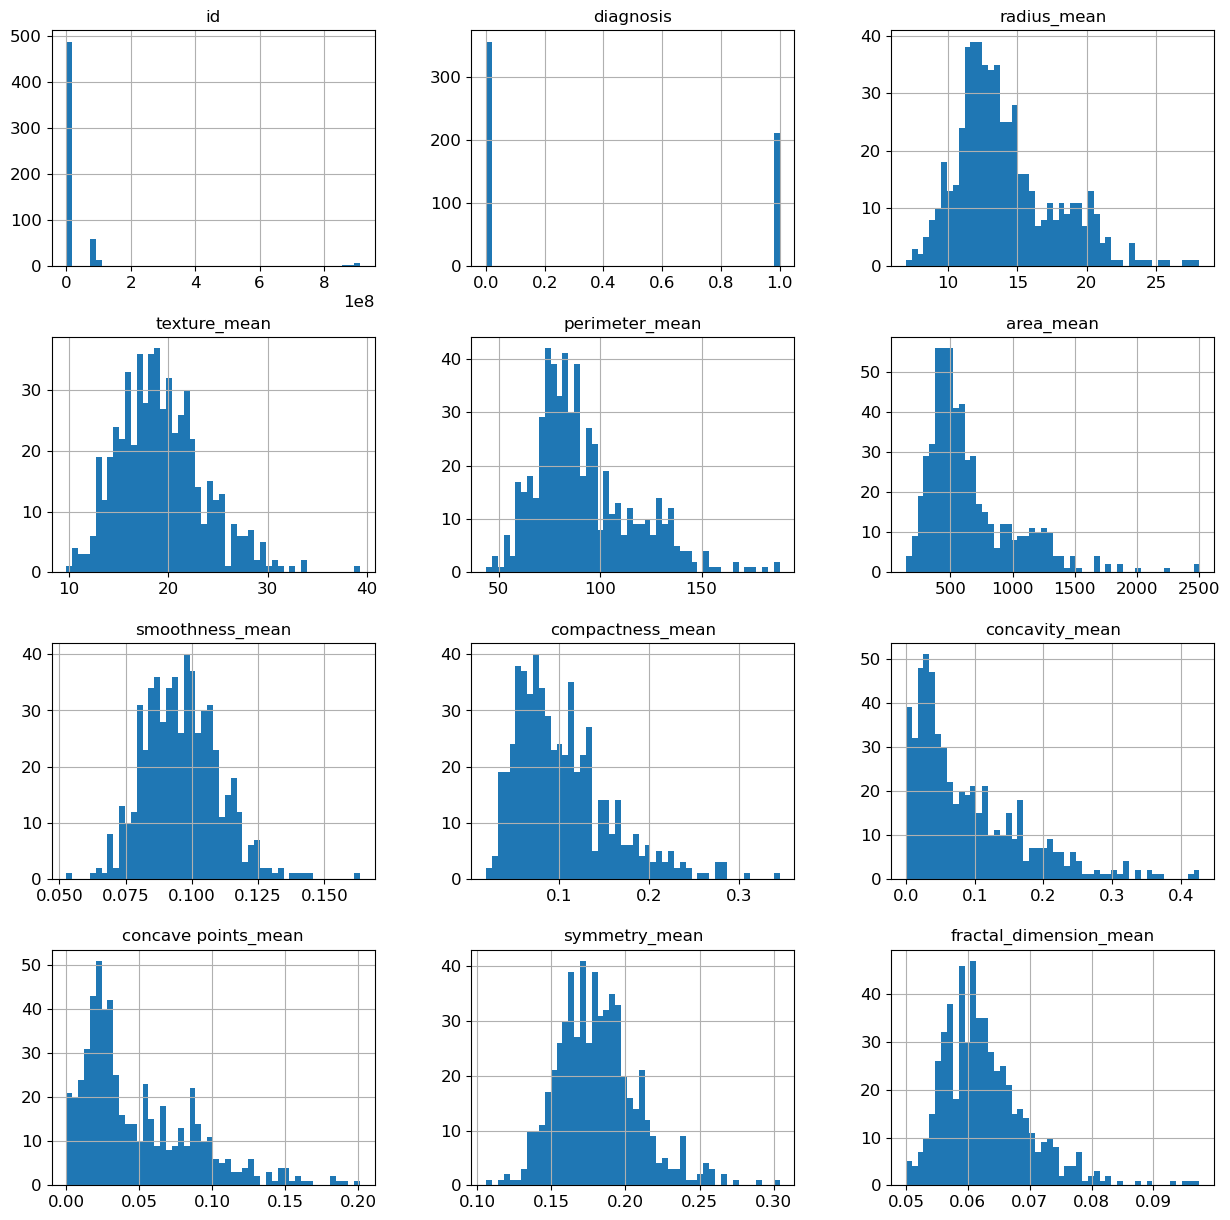

In [4]:
breast_cancer.hist(bins=50, figsize=(15,15))
plt.show()

As seen in the plot above, there are a significant nummber of features in this dataset with a right skew. This could potentially affect the accuracy of our machine learning algorithm. The features need to be scaled before being fed into the machine learning algorithm. 

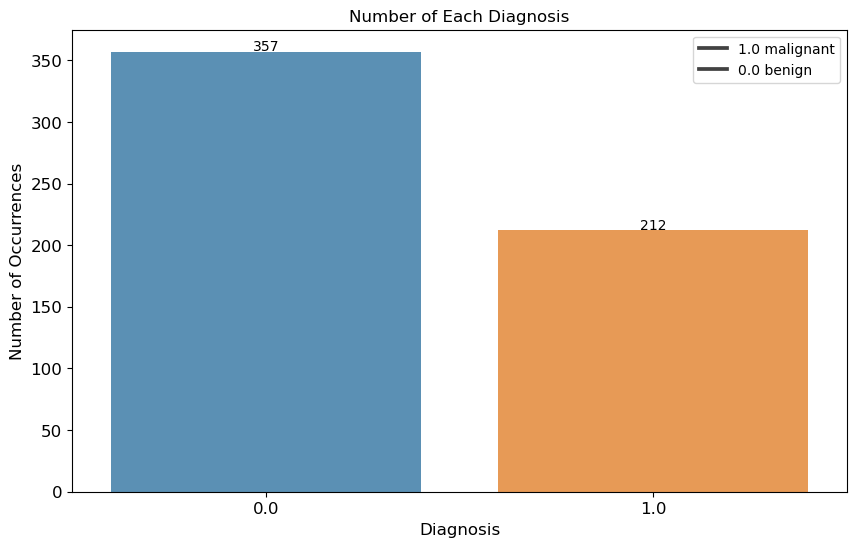

In [5]:
import seaborn as sns

# Count the number of each class
class_balance = breast_cancer['diagnosis'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=class_balance.index, y=class_balance.values, alpha=0.8)

plt.title('Number of Each Diagnosis')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Diagnosis', fontsize=12)

# Add count labels to the top of each bar
for i, v in enumerate(class_balance.values):
    plt.text(i, v + 10, str(v), ha='center', va='top')

# Add legend
plt.legend(labels=['1.0 malignant', '0.0 benign'])

plt.show()

The plot above shows the number of diagnosis for malignant and benign in our breast cancer dataset. It can be observed from the plot that there are significantly more examples of benign tumors when compared to malignant tumors. This could cause bias in both the logistic regression and decision tree classifiers in later steps.

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = breast_cancer.drop(['diagnosis', 'id'], axis=1)
y = breast_cancer['diagnosis']

cn_train_X, cn_test_X, cn_train_y, cn_test_y = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
cn_train_X = scaler.fit_transform(cn_train_X)
cn_test_X = scaler.transform(cn_test_X)

cn_train_X = pd.DataFrame(cn_train_X, columns=X.columns)
cn_test_X = pd.DataFrame(cn_test_X, columns=X.columns)

## 1.1 Training Models

### 1.1.1 Logistic Regression Classifier

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'solver': ['newton-cg', 'lbfgs'], 
        'penalty': ['l2'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    },
    {
        'solver': ['liblinear'], 
        'penalty': ['l1', 'l2'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    }
]

grid_search = GridSearchCV(LogisticRegression(random_state=123, max_iter=400), param_grid, cv=3, scoring='recall') 

# Train the models
grid_search.fit(cn_train_X, cn_train_y)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Print the best cross-validation score
print("Best cross-validation score:", grid_search.best_score_)

Best hyperparameters: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Best cross-validation score: 0.9052840434419381


The cell above shows the grid search to find the best hyperparameters for the logistic regression classifier. 3 hyperparameters are being tuned in this search:
- solver: Algorithm to use in the optimization problem. We are choosing between lbfgs, which is the default solver and liblinear, which performs well on small datasets. 
- penalty: The penalty applied to the algorithm
- C: Controls the inverse of the regularization strength. Smaller values of C increase regularization, reducing the risk of overfitting.


The scoring method chosen for this grid search is recall, not accuracy. It was observed in an earlier plot that the dataset is not balanced. Accuracy calculates the overall correctness of predictions by considering the ratio of correctly classified instances to the total number of instances. However, in imbalanced datasets, where one class is significantly more prevalent than the other, accuracy can be misleading.

Recall is defined as the ratio of true positives (TP) to the sum of true positives and false negatives (FN). When considering the cancer dataset, we want a classifier with as high a recall as possible. A high recall value indicates that the model is correctly identifying a large proportion of the positive instances. In terms of the cancer dataset, a true positive would mean a malignant tumor while a false negative would mean a malignant tumor that was falsely classified as benign. We do not want any false negatives as a missed cancer diagnosis could be potentially fatal to the patient. Therefore, recall was chosen as the scoring metic. 

Based on this, the best hyperparameters are:
- solver: newton-cg
- penalty: l2
- C: 100

In [8]:
log_reg = LogisticRegression(solver='newton-cg', penalty='l2', C=100, random_state=123)
log_reg.fit(cn_train_X, cn_train_y)
y_pred_log = log_reg.predict(cn_test_X)

print(classification_report(cn_test_y, y_pred_log))

              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95        71
         1.0       0.91      0.93      0.92        43

    accuracy                           0.94       114
   macro avg       0.93      0.94      0.93       114
weighted avg       0.94      0.94      0.94       114



## 1.1.2 Decision Tree Classifier

In [9]:
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 5, 7, 9],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_features': [None, 'sqrt', 'log2'],
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=123), param_grid, cv=3, scoring='recall') 

# Train the models
grid_search.fit(cn_train_X, cn_train_y)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Print the best cross-validation score
print("Best cross-validation score:", grid_search.best_score_)

Best hyperparameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation score: 0.922827903091061


The cell above shows the grid search to find the best hyperparameters for the Decision Tree classifier. 5 hyperparameters are being tuned in this search:

- criterion:  Decision trees use a criterion to measure the quality of a split at each node. The two common options are 'gini' and 'entropy'. Tuning this hyperparameter allows the model to select the criterion that results in the best splits, leading to more accurate and informative decision trees.
- max_depth: This hyperparameter determines the maximum depth or levels allowed in the decision tree. Tuning max_depth helps control the complexity of the tree. A shallow tree (low max_depth) may underfit the data, while a deep tree (high max_depth) can overfit. By trying different values, the optimal depth can be found that balances between capturing useful patterns and avoiding excessive complexity.
- min_samples_split: This hyperparameter sets the minimum number of samples required to split an internal node. By tuning min_samples_split, you control the threshold for splitting nodes. Smaller values can result in more partitions, potentially capturing more specific patterns but increasing the risk of overfitting. Larger values promote generalization by requiring a higher number of samples for node splitting.
- min_samples_leaf: Similar to min_samples_split, min_samples_leaf sets the minimum number of samples required to be at a leaf node. It controls the granularity of the decision tree. Smaller values allow the tree to capture more specific patterns but can lead to overfitting, while larger values promote generalization but may result in underfitting.
- max_features: This hyperparameter determines the maximum number of features to consider when looking for the best split. By trying different options such as 'sqrt' (square root of the total features) or 'log2' (log base 2 of the total features), you can control the randomness of feature selection during tree building. Tuning max_features helps to reduce overfitting and improve the model's ability to generalize.

The scoring used is `recall` detailed reasoning was explained in section 1.1.1.

The best hyperparameters from the grid search:
- criterion: entropy
- max_depth: 2
- min_samples_split: 2
- min_samples_leaf: 1
- max_features: None

In [10]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, random_state=123)
tree.fit(cn_train_X, cn_train_y)
y_pred_tree = tree.predict(cn_test_X)

print(classification_report(cn_test_y, y_pred_tree))


              precision    recall  f1-score   support

         0.0       0.97      0.89      0.93        71
         1.0       0.84      0.95      0.89        43

    accuracy                           0.91       114
   macro avg       0.90      0.92      0.91       114
weighted avg       0.92      0.91      0.91       114



### 1.1.3 Comparing the two classifiers

- Accuracy
- Precison/recall
- Confusion matrices

In [11]:
def plot_accuracy(y_pred_1, y_pred_2, name1, name2, flag):
    colors = ['#8dd3c7', '#bebada']
    if flag == 'train':
        accuracy_score1 = accuracy_score(cn_train_y, y_pred_1)
        accuracy_score2 = accuracy_score(cn_train_y, y_pred_2)
    elif flag == 'test':
        accuracy_score1 = accuracy_score(cn_test_y, y_pred_1)
        accuracy_score2 = accuracy_score(cn_test_y, y_pred_2)
        
    # Create a bar chart
    plt.figure(figsize=(6, 4))
    plt.bar([name1, name2], [accuracy_score1, accuracy_score2], alpha=0.8, color=colors)

    plt.title('Accuracy comparison ' + flag + ' set')
    plt.ylabel('Accuracy')
    plt.xlabel('Classifiers')

    # Add value labels to the top of each bar
    for i, v in enumerate([accuracy_score1, accuracy_score2]):
        plt.text(i, v + 0.01, str(v), ha='center', va='bottom')

    plt.show()
 

In [12]:
from sklearn.metrics import precision_score, recall_score

def plot_precision(y_pred_1, y_pred_2, name1, name2, flag):
    colors = ['#8dd3c7', '#bebada']
    if flag == 'train':
        accuracy_score1 = precision_score(cn_train_y, y_pred_1)
        accuracy_score2 = precision_score(cn_train_y, y_pred_2)
    elif flag == 'test':
        accuracy_score1 = precision_score(cn_test_y, y_pred_1)
        accuracy_score2 = precision_score(cn_test_y, y_pred_2)
        
    # Create a bar chart
    plt.figure(figsize=(6, 4))
    plt.bar([name1, name2], [accuracy_score1, accuracy_score2], alpha=0.8, color=colors)

    plt.title('Precision comparison ' + flag + ' set')
    plt.ylabel('Accuracy')
    plt.xlabel('Classifiers')

    # Add value labels to the top of each bar
    for i, v in enumerate([accuracy_score1, accuracy_score2]):
        plt.text(i, v + 0.01, str(v), ha='center', va='bottom')

    plt.show()

In [13]:
def plot_recall(y_pred_1, y_pred_2, name1, name2, flag):
    colors = ['#8dd3c7', '#bebada']
    if flag == 'train':
        accuracy_score1 = recall_score(cn_train_y, y_pred_1)
        accuracy_score2 = recall_score(cn_train_y, y_pred_2)
    elif flag == 'test':
        accuracy_score1 = recall_score(cn_test_y, y_pred_1)
        accuracy_score2 = recall_score(cn_test_y, y_pred_2)
        
    # Create a bar chart
    plt.figure(figsize=(6, 4))
    plt.bar([name1, name2], [accuracy_score1, accuracy_score2], alpha=0.8, color=colors)

    plt.title('Recall comparison ' + flag + ' set')
    plt.ylabel('Accuracy')
    plt.xlabel('Classifiers')

    # Add value labels to the top of each bar
    for i, v in enumerate([accuracy_score1, accuracy_score2]):
        plt.text(i, v + 0.01, str(v), ha='center', va='bottom')

    plt.show()

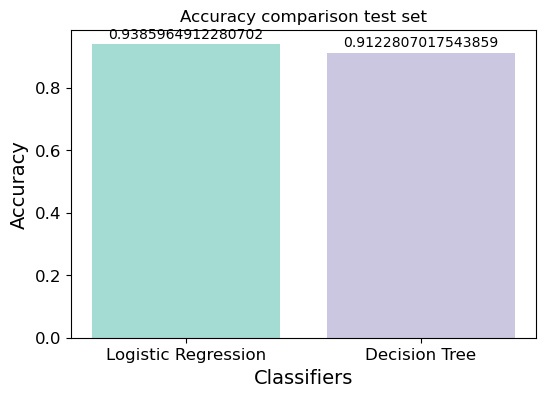

In [14]:
plot_accuracy(y_pred_log, y_pred_tree, 'Logistic Regression', 'Decision Tree', 'test')

Accuracy represents the proportion of correctly classified instances out of the total number of instances in a dataset. To calculate accuracy, you compare the predicted labels generated by the algorithm to the true labels of the dataset. The algorithm assigns a predicted label to each instance based on the learned patterns and features from the training data. The accuracy is then determined by dividing the number of correctly predicted instances by the total number of instances:

Accuracy = (Number of correctly predicted instances) / (Total number of instances)

As mentioned before, accuracy is a useful metric when the dataset is well-balanced. In our situation, although the logistic regression classifier has a sligtly higher accuracy when compared to the decision tree clasifier, this in inconclusive and we will not use it in our selection of a best classifier. 

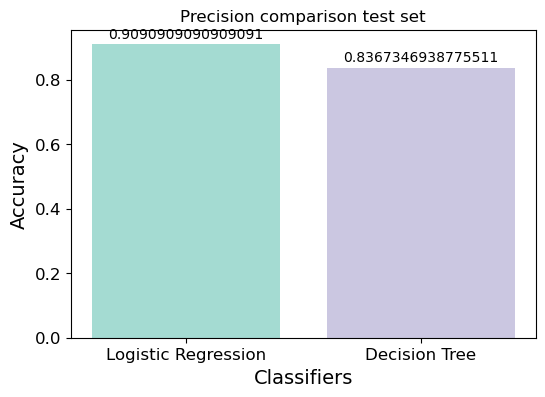

In [15]:
plot_precision(y_pred_log, y_pred_tree, 'Logistic Regression', 'Decision Tree', 'test')

Precision is defined as the ratio of true positives (TP) to the sum of true positives and false positives (FP):

Precision = TP / (TP + FP)

In other words, precision measures the proportion of correct positive predictions out of all the positive predictions made by the model. A high precision value indicates that the model is making very few false positive predictions. In terms of the cancer dataset, a true positive would mean a malignant tumor while a false positive would mean a benign tumor that was falsely classified as malignant.

Precision is particularly important when the cost of false positives is high. In this case, this is not true. While it can be argued that a false positive prediction could cause additional stress to the patient, additional tests can be performed that shows that the patient is indeed benign.

Contary to the data, for the cancer dataset we would actually prefer the decision tree classifier with it's lower precision. It is more important for us to catch 100% of the malignant diagnoses.

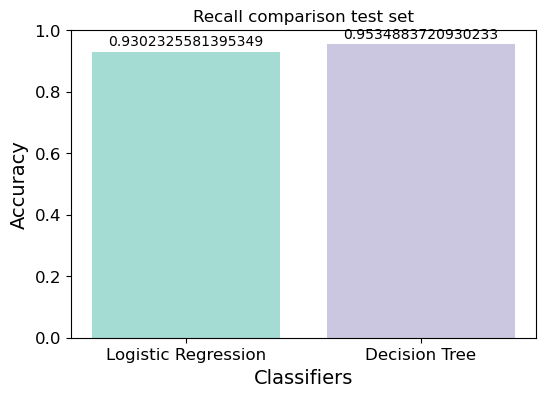

In [16]:
plot_recall(y_pred_log, y_pred_tree, 'Logistic Regression', 'Decision Tree', 'test')

Recall is defined as the ratio of true positives (TP) to the sum of true positives and false negatives (FN):

Recall = TP / (TP + FN)

Recall is defined as the ratio of true positives (TP) to the sum of true positives and false negatives (FN). When considering the cancer dataset, we want a classifier with as high a recall as possible. A high recall value indicates that the model is correctly identifying a large proportion of the positive instances. In terms of the cancer dataset, a true positive would mean a malignant tumor while a false negative would mean a malignant tumor that was falsely classified as benign. 

Based on our needs, we would prefer the decision tree classifier as it has a higher recall (0.95) when compared to the logistic regression classifier (0.93). We want to capture all the true positives while avoiding false negatives so as to avoid patients who have malignant tumors slipping through. 

## 1.2 High Impact Features

### 1.2.1 Logistic Regression Classifier

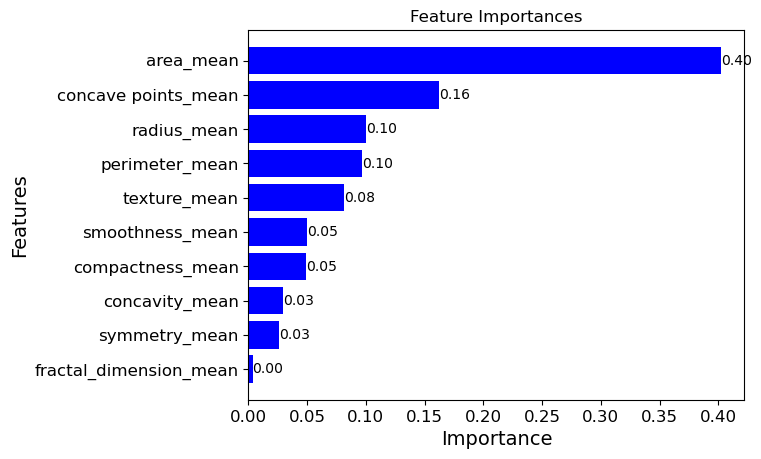

In [17]:
# Get the absolute magnitudes of the coefficients
coef_magnitudes = np.abs(log_reg.coef_[0])

# Normalize the magnitudes
norm_coef_magnitudes = coef_magnitudes / np.sum(coef_magnitudes)

# Sort the features by their normalized magnitudes in descending order
sorted_features = sorted(zip(cn_train_X.columns, norm_coef_magnitudes), key=lambda x: x[1], reverse=True)

# Extract the feature names and magnitudes in the reversed order
features, magnitudes = zip(*sorted_features[::-1])

# Set the color for zero coefficients
color_map = ['red' if magnitude == 0 else 'blue' for magnitude in magnitudes]

# Plot the feature importances
fig, ax = plt.subplots()
bars = ax.barh(range(len(features)), magnitudes, color=color_map)
plt.yticks(range(len(features)), features)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances')

# Add values at the end of each bar
for i, bar in enumerate(bars):
    ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{magnitudes[i]:.2f}',
            ha='left', va='center', color='black')

plt.show()


The plot above shows the feature importances as determined by the logistic regression classifier. In a logistic regression model, feature importances are typically not directly available like in some other models such as decision trees or random forests. Therefore, we will determine the importance of features by examining the coefficients associated with each feature.

It can be observed from the plot that the coefficients for area_mean is 0.40 and concave points_mean is 0.16. These two features account for over half of the feature importance in the model, with area_mean being particularly impactful. It can be noted that fractal_dimension_mean has a weight of 0. Having zero coefficients means that the corresponding features have no influence on the predicted probabilities or decisions made by the logistic regression model. These features can be considered as effectively excluded from the model and can be omitted in further analysis or model interpretation.

### 1.2.2 Decision Tree Classifier

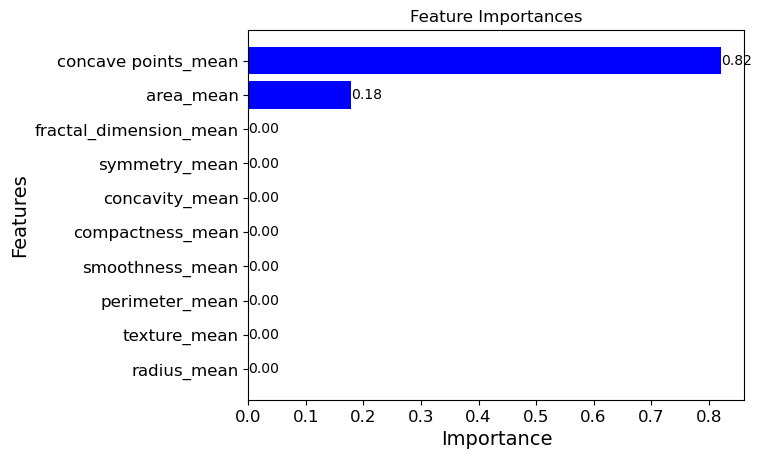

In [18]:
# Get the feature importances from the decision tree classifier
importances = tree.feature_importances_

# Get the indices of the features sorted by importances in descending order
sorted_indices = importances.argsort()[::-1]

# Sort the features and importances accordingly in reversed order
sorted_features = [cn_train_X.columns[i] for i in sorted_indices[::-1]]
sorted_importances = importances[sorted_indices[::-1]]

# Plot the feature importances
fig, ax = plt.subplots()
bars = ax.barh(range(len(sorted_features)), sorted_importances, color='blue')
plt.yticks(range(len(sorted_features)), sorted_features)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances')

# Add values at the end of each bar
for i, bar in enumerate(bars):
    ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{sorted_importances[i]:.2f}',
            ha='left', va='center', color='black')

plt.show()

Similar to the logistic regression classifier, only two features have feature importances greater than 0. Like the logistic regression classifier, concave points_mean dominate the importance chart, with 0.82 of the importances. However, the secondary feature is different being area_mean with 0.18. 

If some of the feature importances are zero, it means that those features did not contribute to the impurity reduction during the construction of the decision tree. There are a few reasons why this might happen:
- Correlated features: If there are highly correlated features in the dataset, the decision tree might select one of the correlated features as the most informative and assign zero importance to the others. This happens because the correlated features provide similar information and contribute similarly to impurity reduction.
- Maximum depth or split limitations: If the decision tree is limited in terms of maximum depth or the minimum number of samples required for a split, it might not have enough levels or splits to capture the importance of certain features. Given that the grid search found a max_depth=2, this is highly likely.



## 1.3 Principal Component Analysis

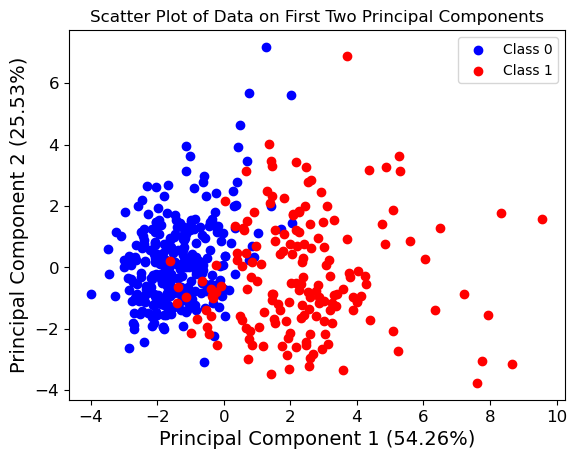

In [19]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(cn_train_X)

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Create a scatter plot with different colors for the two classes
plt.scatter(principal_components[cn_train_y == 0, 0], principal_components[cn_train_y == 0, 1], c='blue', label='Class 0')
plt.scatter(principal_components[cn_train_y == 1, 0], principal_components[cn_train_y == 1, 1], c='red', label='Class 1')

plt.xlabel(f'Principal Component 1 ({explained_variance_ratio[0]*100:.2f}%)')
plt.ylabel(f'Principal Component 2 ({explained_variance_ratio[1]*100:.2f}%)')
plt.title('Scatter Plot of Data on First Two Principal Components')
plt.legend()
plt.show()


In [20]:
pca.explained_variance_ratio_

array([0.54258606, 0.25533396])

The plot above shows the scatter plot of the data on the first two principal components. We can observe the following:
- Class Separation: The scatter plot shows that the two classes are linearly seperable in the reduced two-dimensional space. This indicates that the first two principal components capture meaningful information that helps distinguish between the classes.

The explained variance ratio provides insight into the relative importance or contribution of each principal component in capturing the underlying structure of the data. Higher values indicate that the corresponding principal component retains more information about the original dataset.

These values indicate that the first principal component explains approximately 54.29% of the total variance in the dataset, while the second principal component explains approximately 25.90% of the total variance. Together, these two components account for a total of approximately 80.19% of the total variance in the data.

The first principal component captures a significant portion of the variance, indicating that it carries valuable information and potentially separates the classes to a certain extent. The second principal component also contributes to the overall variance, but to a lesser extent compared to the first component.

## 1.4 Biplot with variable vectors

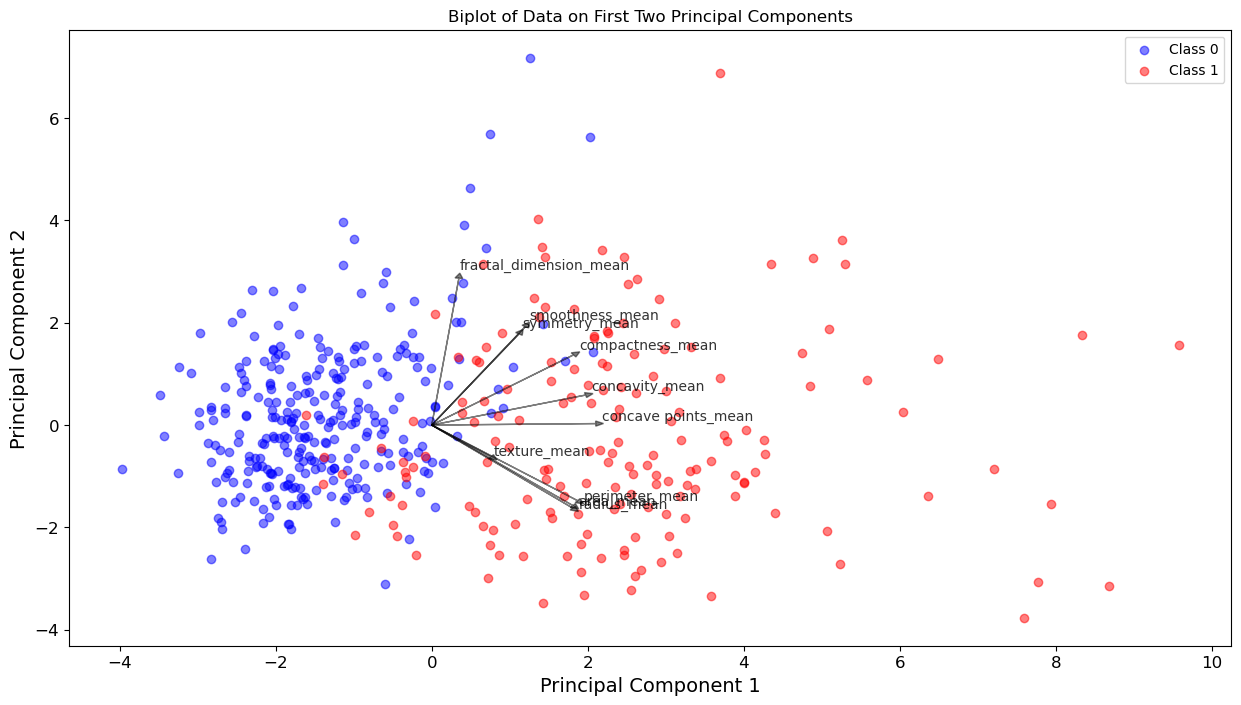

In [21]:
# Get the variable vectors (loadings)
variable_vectors = pca.components_.T

# Create a larger figure with a specific size
fig, ax = plt.subplots(figsize=(15, 8))

# Create a scatter plot of the observed data projected on the first two principal components (with semi-transparent markers)
plt.scatter(principal_components[cn_train_y == 0, 0], principal_components[cn_train_y == 0, 1], c='blue', label='Class 0', alpha=0.5)
plt.scatter(principal_components[cn_train_y == 1, 0], principal_components[cn_train_y == 1, 1], c='red', label='Class 1', alpha=0.5)

# Add variable vectors as arrows with text annotations at the ends
for i, (x, y) in enumerate(variable_vectors):
    plt.arrow(0, 0, x * 5, y * 5, color='black', alpha=0.5, head_width=0.1, head_length=0.1)
    plt.text(x * 5.2, y * 5.2, cn_train_X.columns[i], ha='left', va='bottom', alpha=0.8)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Biplot of Data on First Two Principal Components')
plt.legend()
plt.show()

Fractal dimension mean and concave points mean are most related to tumor status

- first principal component holds alot more information
- cluster of highly correlated components at the bototm
- x axis is more important ( points away from decision boundary)
- y axis ones are sitting on the decision boundary 

## 1.5 95% of the explained variance

In [22]:
# Perform PCA
pca = PCA()
pca.fit(cn_train_X)

# Calculate cumulative explained variance ratio
cumsum = np.cumsum(pca.explained_variance_ratio_)

# Determine the number of components for 95% explained variance
n_components = np.argmax(cumsum >= 0.95) + 1

print(f"Number of components for 95% explained variance: {n_components}")

pca = PCA(n_components=0.95)
cn_train_X_red = pca.fit_transform(cn_train_X)
cn_test_X_red = pca.transform(cn_test_X)

Number of components for 95% explained variance: 5


In [23]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 5, 7, 9],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_features': [None, 'sqrt', 'log2'],
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=123), param_grid, cv=3, scoring='recall') 

# Train the models
grid_search.fit(cn_train_X_red, cn_train_y)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Print the best cross-validation score
print("Best cross-validation score:", grid_search.best_score_)

Best hyperparameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2}
Best cross-validation score: 0.8993316624895572


As stated in Section 1.1.3, we prefer the decision tree model due to it's higher recall given the nature of our dataset. Therefore, it will be our model of choice for this reduced dimensional dataset. The grid search is run again to determine the optimal hyperparameters.

- criterion: gini
- max_depth: None
- min_samples_split: 2
- min_samples_leaf: 3
- max_features: Sqrt

In [24]:
tree_red = DecisionTreeClassifier(criterion='gini', max_depth=None, max_features='sqrt', min_samples_leaf=3, min_samples_split=2, random_state=123)
tree_red.fit(cn_train_X_red, cn_train_y)
y_pred_tree_red = tree_red.predict(cn_test_X_red)

print(classification_report(cn_test_y, y_pred_tree_red))

              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95        71
         1.0       0.91      0.93      0.92        43

    accuracy                           0.94       114
   macro avg       0.93      0.94      0.93       114
weighted avg       0.94      0.94      0.94       114



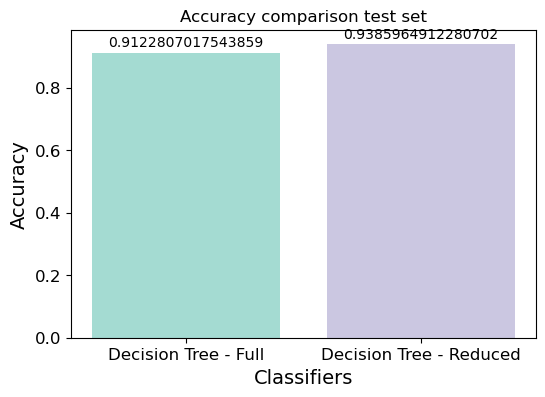

In [25]:
plot_accuracy(y_pred_tree, y_pred_tree_red, 'Decision Tree - Full', 'Decision Tree - Reduced', 'test')

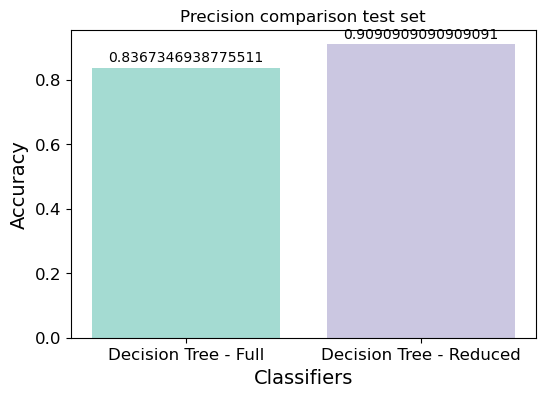

In [26]:
plot_precision(y_pred_tree, y_pred_tree_red, 'Decision Tree - Full', 'Decision Tree - Reduced', 'test')

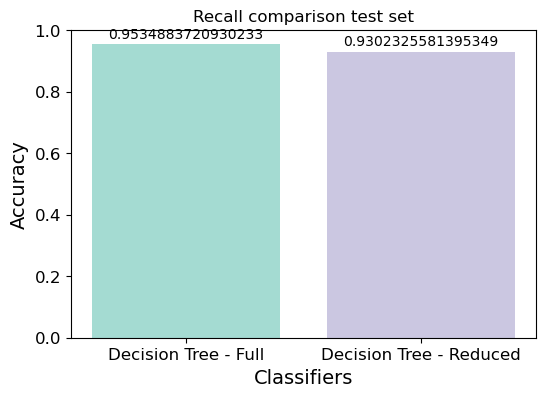

In [27]:
plot_recall(y_pred_tree, y_pred_tree_red, 'Decision Tree - Full', 'Decision Tree - Reduced', 'test')

# 2 A clustering analysis on airlines safety records

In [28]:
airline = pd.read_csv('airline-safety.csv')

In [29]:
airline.head()

,airline,avail_seat_km_per_week,incidents_85_99,fatal_accidents_85_99,fatalities_85_99,incidents_00_14,fatal_accidents_00_14,fatalities_00_14
0,Aer Lingus,320906734,2,0,0,0,0,0
1,Aeroflot*,1197672318,76,14,128,6,1,88
2,Aerolineas Argentinas,385803648,6,0,0,1,0,0
3,Aeromexico*,596871813,3,1,64,5,0,0
4,Air Canada,1865253802,2,0,0,2,0,0


In [30]:
airlines = airline['airline']
airline = airline.drop('airline', axis=1)

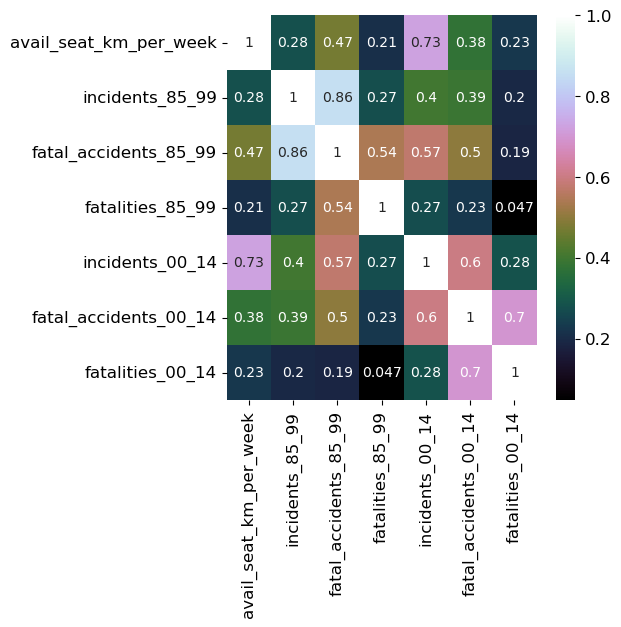

In [31]:
import seaborn as sns

plt.figure(figsize=(5, 5))
sns.heatmap(airline.corr(), cmap='cubehelix', annot=True)
plt.show()

## 2.1 Silhouette score

In [32]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings

def plot_silhouette_score():
    # unscaled data plot
    kmeans_per_k = [KMeans(n_clusters=k, random_state=5508).fit(airline)
                    for k in range(2, 9)]

    silhouette_scores = [silhouette_score(airline, model.labels_)
                         for model in kmeans_per_k]
    warnings.filterwarnings('ignore')

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot for unscaled data
    axs[0].plot(range(2, 9), silhouette_scores, "bo-")
    axs[0].set_xlabel("$k$")
    axs[0].set_ylabel("Silhouette score")
    axs[0].set_title('Silhouette score for unscaled data')
    axs[0].grid()

    # scaled data plot
    scaler = StandardScaler()
    airline_scaled = scaler.fit_transform(airline)
    airline_scaled = pd.DataFrame(airline_scaled, columns=airline.columns)

    kmeans_per_k = [KMeans(n_clusters=k, random_state=5508).fit(airline_scaled)
                    for k in range(2, 9)]

    silhouette_scores = [silhouette_score(airline_scaled, model.labels_)
                         for model in kmeans_per_k]
    warnings.filterwarnings('ignore')


    # Plot for scaled data
    axs[1].plot(range(2, 9), silhouette_scores, "bo-")
    axs[1].set_xlabel("$k$")
    axs[1].set_ylabel("Silhouette score")
    axs[1].set_title('Silhouette score for scaled data')
    axs[1].grid()

    # Adjust spacing between subplots
    plt.tight_layout()

    # Display the plot
    plt.show()

### 2.1.1 Silhouette Score for all features

The silhouette score, is the mean silhouette coefficient over all the instances, it is computed using the formula:
(b – a) / max(a, b)
Where a is the mean distance to the other instances in the same cluster. 

A silhouette score that approaches 1 means that the instance is well seperated and far from any neighbouring clusters. A silhouette score that approaches 0 means that the cluster is close to a boundary. In this case, we would choose k=2 as it has the highest silhouette score. k=3 is a close second.

The graph on the left plots the silhouette score for unscaled data and the graph on the right plots the silhouette score for scaled data. It can be seen that the silhouette scores for the plot on the left are significantly higher than the plot on the right. While this may seem to favour the unscaled data, we will choose to use scaled data as the features are at different scales. From section 2, it can be observed that features like avail_seat_km is 9 orders of magnitude above the others. This will greatly influence clustering. Therefore, we will go with the scaled data despite the lower silhouette score. 


## 2.2 Applying K-means clustering

In [33]:
# Perform K-means clustering
kmeans = KMeans(n_clusters=2, random_state=5508)
kmeans.fit(airline)

# Get the cluster labels
cluster_labels = kmeans.labels_

# Assign the cluster labels to the dataset
airline['Cluster'] = cluster_labels

# Analyze the main characteristics of each group
group1 = airline[airline['Cluster'] == 0]
group2 = airline[airline['Cluster'] == 1]

# # Describe the main characteristics of each group
# print("Group 1:")
# print(group1.describe())
# print("\nGroup 2:")
# print(group2.describe())

C:\Users\Joo_Kai\miniconda3\envs\cits5508-2023\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [34]:
import seaborn as sns

def perform_k_means(selected_features):

    preprocessed_data = airline[selected_features].copy()

    # Handling missing values, if any
    preprocessed_data.fillna(0, inplace=True)

    # Normalize the features using StandardScaler
    scaler = StandardScaler()
    preprocessed_data = scaler.fit_transform(preprocessed_data)

    # Step 3: Apply K-means Clustering
    kmeans = KMeans(n_clusters=4, random_state=5508)
    kmeans.fit(preprocessed_data)

    # Step 4: Interpret the Results
    cluster_labels = kmeans.labels_
    cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)

    # Calculate the mean values of features for each cluster
    cluster_means = pd.DataFrame(cluster_centers, columns=selected_features)
    cluster_means.index = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']

    # Print the cluster means
    print("Cluster Means:")
    print(cluster_means)

    # Count the number of airlines in each cluster
    cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
    print("\nCluster Counts:")
    print(cluster_counts)

    # Step 4: Visualize the Clusters
    cluster_labels = kmeans.labels_

    # Add cluster labels to the preprocessed data
    preprocessed_data_with_clusters = pd.DataFrame(preprocessed_data, columns=selected_features)
    preprocessed_data_with_clusters['Cluster'] = cluster_labels

    # Visualize each feature against each other feature
    sns.set(style="ticks")
    sns.pairplot(preprocessed_data_with_clusters, hue="Cluster")
    
    
    plt.show()

C:\Users\Joo_Kai\miniconda3\envs\cits5508-2023\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Means:
           incidents_85_99  fatalities_85_99  incidents_00_14  \
Cluster 1        10.733333             325.0         6.333333   
Cluster 2         3.342857              28.0         2.714286   
Cluster 3        76.000000             128.0         6.000000   
Cluster 4         9.600000              62.4         7.000000   

           fatalities_00_14  
Cluster 1         49.400000  
Cluster 2         14.828571  
Cluster 3         88.000000  
Cluster 4        352.200000  

Cluster Counts:
0    15
1    35
2     1
3     5
dtype: int64


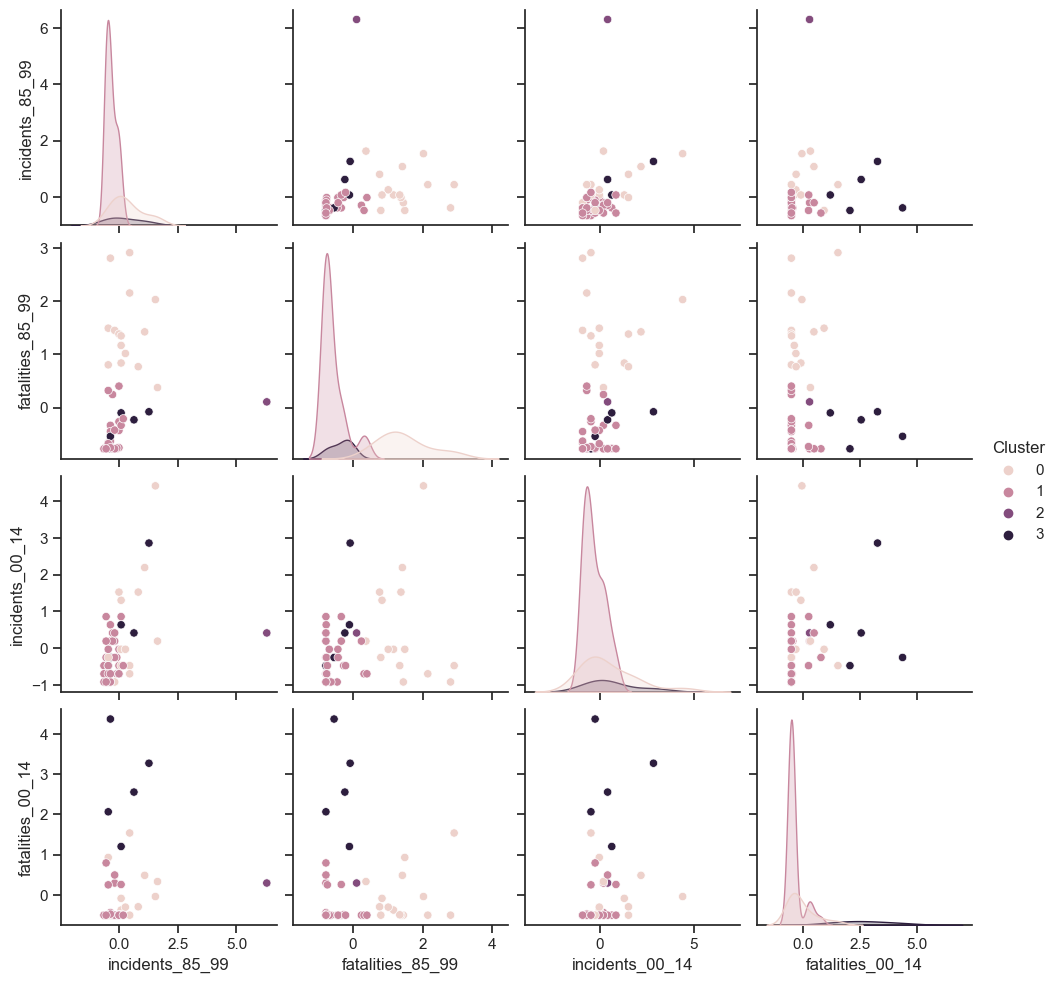

In [35]:
selected_features = ['incidents_85_99', 'fatalities_85_99', 'incidents_00_14', 'fatalities_00_14']
perform_k_means(selected_features)

## 2.3 Explanation 

For the decision to only use 'incidents_85_99', 'fatalities_85_99', 'incidents_00_14', 'fatalities_00_14' in the analysis, the reasons are as follows:
- Relevance: In the case of airline safety, variables related to incidents and fatalities in different time periods would be relevant, such as "incidents_85_99," "fatalities_85_99," "incidents_00_14," and "fatalities_00_14."
- Non-redundancy: We want to avoid including variables that are highly correlated with each other. Redundant variables do not provide additional information and can lead to biased results. It can be seen from the correlation matrix in section 2 that the incidents and fatal accidents features are highly correlated. Therefore, we dropped the fatal accidents feature.

The provided code selects the variables 'incidents_85_99', 'fatalities_85_99', 'incidents_00_14', and 'fatalities_00_14' as they are directly related to safety records and would likely be informative for clustering airlines based on their safety performance.

Scaling:

Improve Convergence: K-means clustering is an iterative algorithm that aims to minimize the within-cluster sum of squares. Scaling the data can improve convergence by ensuring that each feature contributes comparably to the clustering process. Without scaling, features with larger scales may disproportionately affect the clustering process and result in suboptimal clusters.

## 2.4 Selecting Features

### 2.4.1 1985-1999

C:\Users\Joo_Kai\miniconda3\envs\cits5508-2023\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Means:
           incidents_85_99  fatalities_85_99  fatal_accidents_85_99
Cluster 1        18.428571        311.142857               6.857143
Cluster 2         3.605263         26.842105               0.947368
Cluster 3         6.000000        296.900000               2.400000
Cluster 4        76.000000        128.000000              14.000000

Cluster Counts:
0     7
1    38
2    10
3     1
dtype: int64


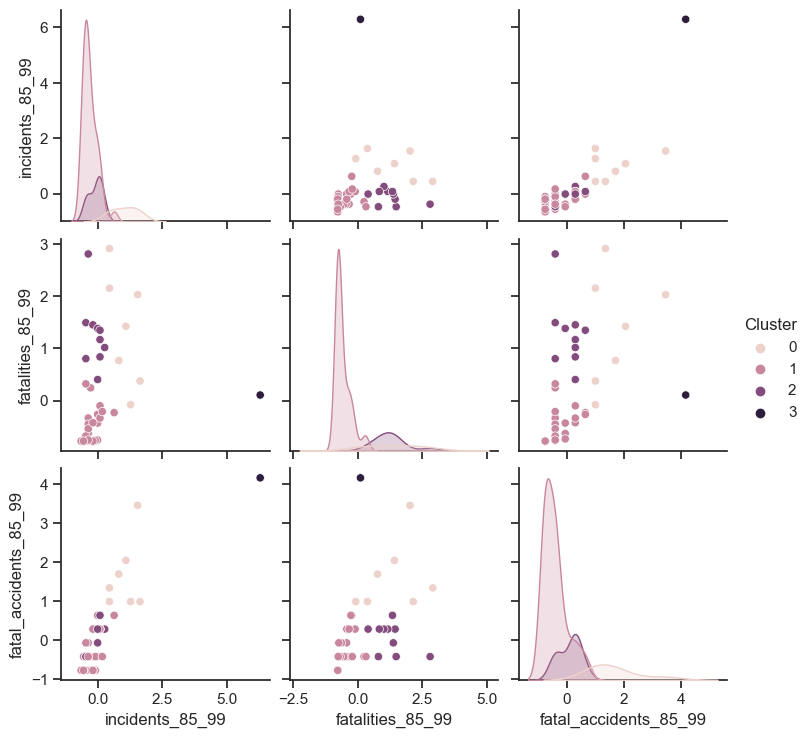

In [36]:
selected_features = ['incidents_85_99', 'fatalities_85_99', 'fatal_accidents_85_99']
perform_k_means(selected_features)

### 2.4.2 2000-2014

C:\Users\Joo_Kai\miniconda3\envs\cits5508-2023\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Means:
           incidents_00_14  fatalities_00_14  fatal_accidents_00_14
Cluster 1         2.486486          0.702703               0.135135
Cluster 2        13.400000         62.600000               2.000000
Cluster 3         8.666667        430.000000               2.333333
Cluster 4         4.181818        134.545455               1.363636

Cluster Counts:
0    37
1     5
2     3
3    11
dtype: int64


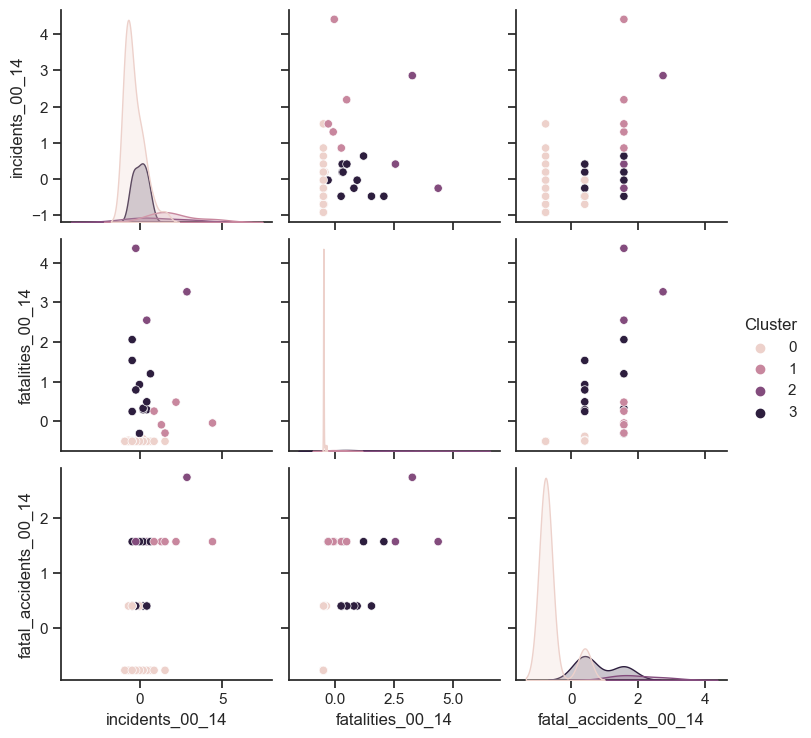

In [37]:
selected_features = ['incidents_00_14', 'fatalities_00_14', 'fatal_accidents_00_14']
perform_k_means(selected_features)

## 2.5 3 New Features

C:\Users\Joo_Kai\miniconda3\envs\cits5508-2023\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Means:
           incidents_divided  fatalities_divided  fatal_accidents_divided
Cluster 1           0.269922            0.103321                 0.095578
Cluster 2           1.000000           14.813725                 1.250000
Cluster 3           0.887054            1.672118                 0.720833
Cluster 4           1.540179            0.015663                 0.020833

Cluster Counts:
0    21
1     2
2     8
3     8
dtype: int64


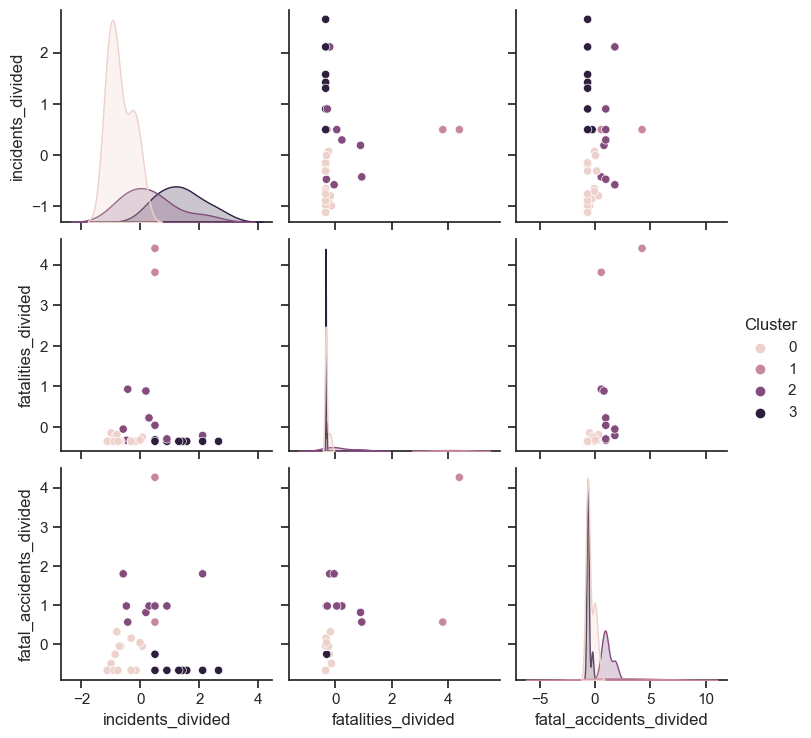

In [38]:
airline['incidents_divided'] = airline['incidents_00_14'] / airline['incidents_85_99']
airline['fatalities_divided'] = airline['fatalities_00_14'] / airline['fatalities_85_99']
airline['fatal_accidents_divided'] = airline['fatal_accidents_00_14'] / airline['fatal_accidents_85_99']

# ADD A SMALL VALUE TO EVER COL 10^-5 or smth AND ROLL WITH IT
airline = airline.replace([np.inf, -np.inf], np.nan)  # Replace inf values with NaN
airline = airline.dropna()  # Drop rows containing NaN values

selected_features = ['incidents_divided', 'fatalities_divided', 'fatal_accidents_divided']
perform_k_means(selected_features)

# 3 A clustering analysis on the USArrests data

In [39]:
arrests = pd.read_csv('USArrests.csv')

In [40]:
arrests.head()

,State,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [41]:
states = arrests['State']
arrests = arrests.drop('State', axis=1)

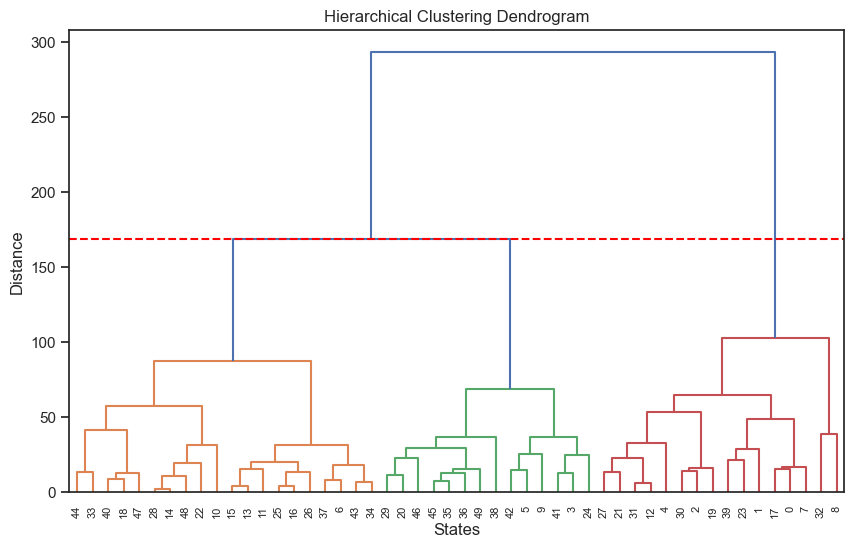

In [42]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

unscaled_arrests = arrests.copy()
linked = linkage(unscaled_arrests, method='complete', metric='euclidean')

# Determine the threshold height
k = 3  # Number of clusters
threshold = linked[-(k - 1), 2]  # Get the height corresponding to k clusters

plt.figure(figsize=(10, 6))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True, color_threshold=threshold)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('States')
plt.ylabel('Distance')



# Plot the threshold as a red dotted line
plt.axhline(y=threshold, color='red', linestyle='--')

# Cut the dendrogram and assign cluster labels
cluster_labels = fcluster(linked, threshold, criterion='distance')

plt.show()

In [43]:
# Assign the cluster labels to the states
arrests['Cluster'] = clusters

# Print the states and their corresponding clusters
# state_clusters = arrests[['State', 'Cluster']]
# print(state_clusters)

NameError: name 'clusters' is not defined

In [ ]:
# Calculate the mean values for each cluster
cluster_means = arrests.groupby('Cluster').mean()

# Print the characteristics of each cluster
print(cluster_means)

In [ ]:
# Prepare the data for clustering
scaled_arrests = arrests.copy()  # Include all columns for clustering

# Scale the variables
scaler = StandardScaler()
scaled_arrests = scaler.fit_transform(scaled_arrests)

# Perform hierarchical clustering
linked = linkage(scaled_arrests, method='complete', metric='euclidean')
# Determine the threshold height
k = 3  # Number of clusters
threshold = linked[-(k - 1), 2]  # Get the height corresponding to k clusters

plt.figure(figsize=(10, 6))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True, color_threshold=threshold)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('States')
plt.ylabel('Distance')
plt.show()
# Cut the dendrogram at height = 200
clusters = fcluster(linked, 4.45, criterion='distance')

# Assign the cluster labels to the states
arrests['Cluster'] = clusters

# Print the states and their corresponding clusters
# state_clusters = arrests[['State', 'Cluster']]
# print(state_clusters)

In [ ]:
# Calculate the mean values for each cluster
cluster_means = arrests.groupby('Cluster').mean()

# Print the characteristics of each cluster
print(cluster_means)

Scaling the variables to have zero mean and unit standard deviation has the effect of standardizing the ranges and magnitudes of the variables. It ensures that all variables contribute equally to the clustering process by eliminating any potential bias due to different scales.

In this specific case, scaling the variables in the USArrests dataset will affect the hierarchical clustering results. Variables with larger magnitudes, such as 'Assault' and 'UrbanPop', might dominate the clustering process if not scaled, potentially overshadowing the influence of variables with smaller magnitudes, such as 'Murder' and 'Rape'. Scaling the variables allows for a more balanced consideration of all variables.

In my opinion, scaling the variables is necessary for hierarchical clustering in this case. By scaling the variables, we ensure that each variable is given equal importance during the clustering process, and the resulting clusters are not biased by the original variable scales. This approach leads to more accurate and meaningful clustering results.

Therefore, I recommend scaling the variables before performing hierarchical clustering in this scenario to obtain reliable and unbiased clusters.

In [ ]:
# Prepare the data for PCA
X = arrests.iloc[:, 1:].values  # Include all columns for PCA

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Perform hierarchical clustering on the first two principal components
linked = linkage(X_pca, method='complete', metric='euclidean')

# Cut the dendrogram at height = 8 to obtain three distinct clusters
clusters = fcluster(linked, 8, criterion='distance')

# Add the cluster labels to the DataFrame
arrests['Cluster'] = clusters

# Scatter plot of the first two principal components with different colors for each cluster
plt.figure(figsize=(10, 6))
colors = ['red', 'green', 'blue']
for cluster in range(1, 4):
    plt.scatter(X_pca[clusters == cluster, 0], X_pca[clusters == cluster, 1], color=colors[cluster - 1], label=f'Cluster {cluster}')
plt.title('PCA Scatter Plot')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()